In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from joblib import dump

from src.config import DADOS_LIMPOS, MODELO_FINAL
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [3]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_households,population_per_househoulds,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   longitude                   17564 non-null  float32 
 1   latitude                    17564 non-null  float32 
 2   housing_median_age          17564 non-null  int8    
 3   total_rooms                 17564 non-null  int16   
 4   total_bedrooms              17564 non-null  int16   
 5   population                  17564 non-null  int16   
 6   households                  17564 non-null  int16   
 7   median_income               17564 non-null  float32 
 8   median_house_value          17564 non-null  int32   
 9   ocean_proximity             17564 non-null  category
 10  median_income_cat           17564 non-null  int64   
 11  rooms_per_households        17564 non-null  float32 
 12  population_per_househoulds  17564 non-null  float32 
 13  bedrooms_per_roo

In [5]:
coluna_target = ["median_house_value"]

coluna_one_hot_encoder = ["ocean_proximity"]

coluna_ordinal_encoder = ["median_income_cat"]

In [6]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)

colunas_robust_scaler

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population',
       'population_per_househoulds', 'rooms_per_households', 'total_bedrooms',
       'total_rooms'],
      dtype='object')

In [7]:
pipeline_robust = Pipeline(steps=[
    ("robust_scaler", RobustScaler()),
    ("poly", PolynomialFeatures(degree=1, include_bias=False))
])

preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
        ("robust_scaler_poly", pipeline_robust, colunas_robust_scaler),
    ],
)

In [8]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [9]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_households,population_per_househoulds,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [10]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


In [11]:
param_grid = {
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1, 2, 3],
    "regressor__reg__alpha": [1E-2, 5E-2, 0.1, 0.25, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0],
}

In [12]:
grid_search = grid_search_cv_regressor(
    regressor=Ridge(),
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution="normal"),
    param_grid=param_grid,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   50.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [13]:
grid_search.fit(X, y)

Fitting 5 folds for each of 33 candidates, totalling 165 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   50.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [14]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 10.0}

In [15]:
grid_search.best_score_

-50450.66227362168

In [16]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
)

coefs

,coeficiente
robust_scaler_poly__longitude,-1.023268
robust_scaler_poly__latitude,-0.957370
one_hot__ocean_proximity_INLAND,-0.460141
robust_scaler_poly__latitude longitude population_per_househoulds,-0.418530
robust_scaler_poly__population_per_househoulds,-0.332581
...,...
robust_scaler_poly__latitude^2 longitude,0.247169
robust_scaler_poly__housing_median_age median_income,0.249335
robust_scaler_poly__latitude median_income population_per_househoulds,0.253952
robust_scaler_poly__bedrooms_per_room,0.337635


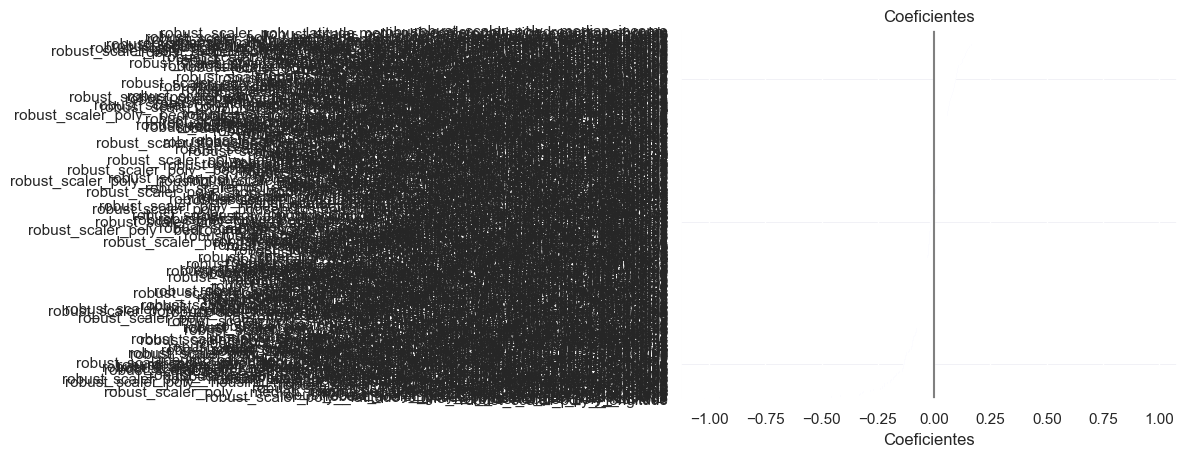

In [17]:
plot_coeficientes(coefs)

In [18]:
coefs[coefs["coeficiente"] == 0]

,coeficiente


In [19]:
coefs[coefs["coeficiente"].between(-0.2, 0.2) & (coefs["coeficiente"] != 0)]

,coeficiente
one_hot__ocean_proximity_NEAR BAY,-0.197772
robust_scaler_poly__housing_median_age population_per_househoulds total_bedrooms,-0.197256
robust_scaler_poly__longitude median_income,-0.189891
robust_scaler_poly__households median_income^2,-0.182289
robust_scaler_poly__housing_median_age median_income population_per_househoulds,-0.181782
...,...
robust_scaler_poly__total_bedrooms,0.169354
robust_scaler_poly__bedrooms_per_room rooms_per_households total_bedrooms,0.172941
robust_scaler_poly__median_income population population_per_househoulds,0.176900
robust_scaler_poly__median_income population rooms_per_households,0.177706


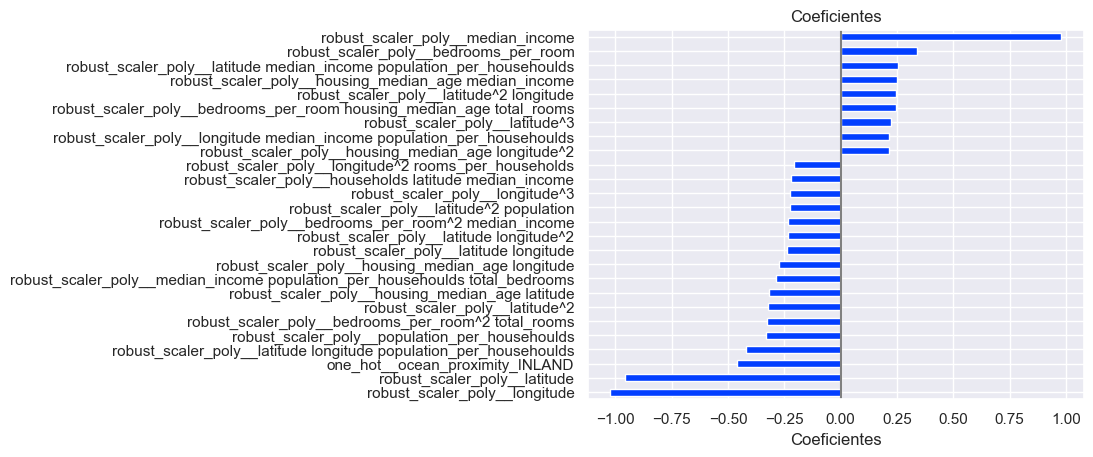

In [20]:
plot_coeficientes(coefs[~coefs["coeficiente"].between(-0.2, 0.2)])

In [21]:
regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_target": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": QuantileTransformer(output_distribution="normal"),
    },
    "Ridge_grid_search": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}


resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.006559,0.007373,-0.000081,-77516.042766,-96239.705692,0.013932
1,DummyRegressor,0.004001,0.006553,-0.000146,-75787.787194,-95217.629397,0.010554
2,DummyRegressor,0.004987,0.00505,-0.001737,-76753.598961,-96253.253947,0.010037
3,DummyRegressor,0.003013,0.006511,-0.000101,-76837.804811,-95983.885799,0.009524
4,DummyRegressor,0.00451,0.006233,-0.000114,-76617.245449,-96182.764729,0.010744
5,LinearRegression,0.080611,0.013997,0.682162,-39855.690996,-54254.958188,0.094607
6,LinearRegression,0.046712,0.015198,0.66999,-40272.565467,-54695.230283,0.061909
7,LinearRegression,0.049983,0.016518,0.649247,-42178.05929,-56955.988706,0.066501
8,LinearRegression,0.043463,0.013928,0.669873,-40806.492497,-55146.318803,0.057391
9,LinearRegression,0.04792,0.015904,0.669023,-40788.496497,-55331.35106,0.063824


In [22]:
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.004614,0.006344,-0.000436,-76702.495836,-95975.447913,0.010958
LinearRegression,0.053738,0.015109,0.668059,-40780.26095,-55276.769408,0.068847
LinearRegression_target,0.066809,0.017439,0.678146,-38675.418204,-54426.423478,0.084248
Ridge_grid_search,0.257184,0.03208,0.723303,-35347.32763,-50455.933141,0.289264


In [23]:
df_resultados.groupby("model").mean().sort_values(by="test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.004614,0.006344,-0.000436,-76702.495836,-95975.447913,0.010958
LinearRegression,0.053738,0.015109,0.668059,-40780.26095,-55276.769408,0.068847
LinearRegression_target,0.066809,0.017439,0.678146,-38675.418204,-54426.423478,0.084248
Ridge_grid_search,0.257184,0.03208,0.723303,-35347.32763,-50455.933141,0.289264


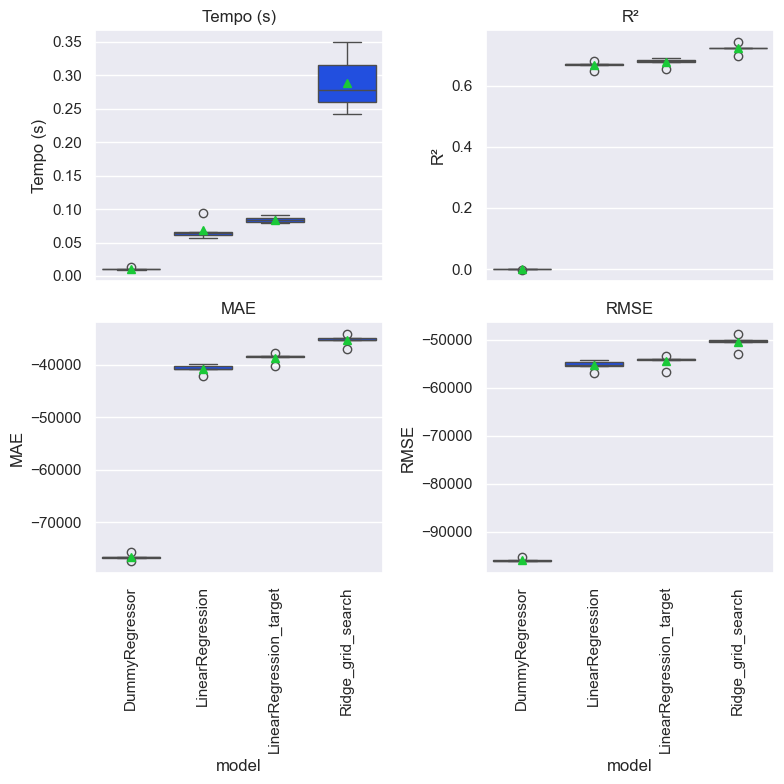

In [24]:
plot_comparar_metricas_modelos(df_resultados)

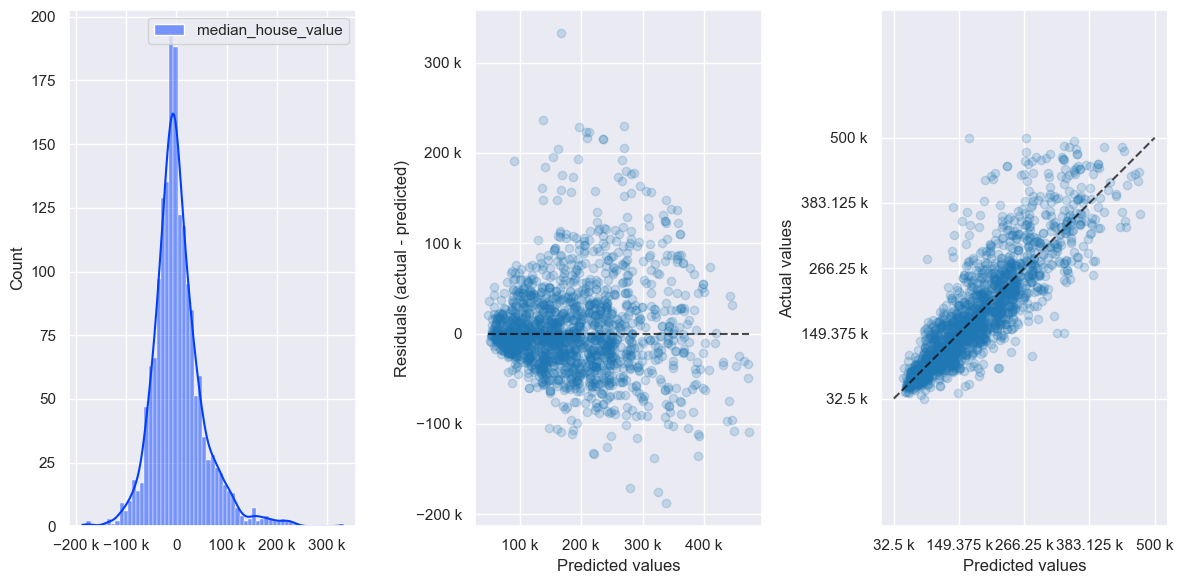

In [25]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)

https://scikit-learn.org/stable/model_persistence.html

In [27]:
dump(grid_search.best_estimator_, MODELO_FINAL)

['C:\\Users\\rafae\\OneDrive\\Cursos\\Hashtag\\Ciencias de dados\\projetos\\05-projeto\\modelos\\ridge_polyfeat_target_quantile.joblib']